In [1]:
!pip install -U -q segmentation-models
#!pip install -q tensorflow==2.2.1
#!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


In [2]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
#import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

In [7]:
!pip install --upgrade pip
#!pip install --upgrade protobuf
#sm.set_framework("tf.keras")

  Using cached pip-23.3.1-py3-none-any.whl.metadata (3.5 kB)
Using cached pip-23.3.1-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Users\hamid\anaconda3\envs\MachineLearning\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
def data_loader(folder_dir):
    image_dataset = []
    
    for images in os.listdir(folder_dir):
        image = cv2.imread(folder_dir+"/"+images, 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return image_dataset

In [ ]:
image_dataset = data_loader(r"E:\python\mathmatic\datas\archive\dataset\semantic_drone_dataset\original_images")
mask_dataset = data_loader(r"E:\python\mathmatic\datas\archive\RGB_color_image_masks\RGB_color_image_masks")

In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [ ]:
image_dataset.shape

In [ ]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show();

In [ ]:
mask_labels = pd.read_csv(r"E:\python\mathmatic\datas\archive\class_dict_seg.csv")
mask_labels

In [8]:
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape, dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1, 2, 3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]
    return label_seg

In [9]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels)
    labels.append(label)

In [10]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


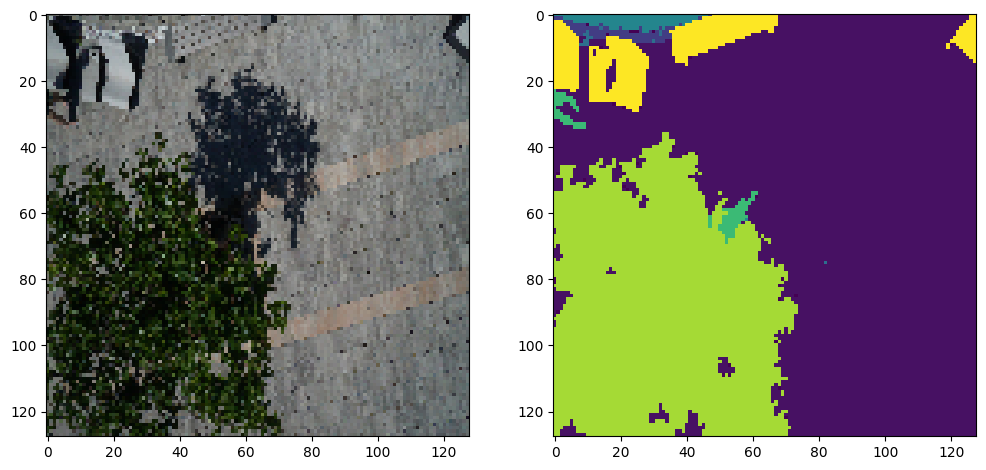

In [11]:
print("Unique labels in label dataset are: ", np.unique(labels))

image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show();

In [12]:
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size=0.2, random_state=42)

In [14]:
BACKBONE = "resnet34"
preprocess_input = sm.get_preprocessing(BACKBONE)

NameError: name 'sm' is not defined

In [ ]:
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [73]:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights="imagenet", classes=n_classes, activation='softmax')

In [75]:
metrics = ['accuracy']
model_resnet_backbone.compile(loss=tf.keras.losses.categorical_crossentropy,
                             optimizer=tf.keras.optimizers.Adam(),
                             metrics=metrics)

In [76]:
model_resnet_backbone.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_102 (ZeroPaddin  (None, None, None,   0          ['bn_data[0][0]']                
 g2D)                           3)                                                          

                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_49[0][0]']                 
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_108 (ZeroPaddin  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 g2D)                           64)                                                               
                                                                                                  
 stage1_un

                                128)                              'add_51[0][0]']                 
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_52[0][0]']                 
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padding2d_114 (ZeroPaddin  (None, None, None,   0          ['stage2_unit3_relu1[0][0]']     
 g2D)                           128)                                                              
          

 add_55 (Add)                   (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_55[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_120 (ZeroPaddin  (None, None, None,   0          ['stage3_unit2_relu1[0][0]']     
 g2D)     

                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_58[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_126 (ZeroPaddin  (None, None, None,   0          ['stage3_unit5_relu1[0][0]']     
 g2D)                           256)                                                              
                                                                                                  
 stage3_un

                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_61[0][0]']                 
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 zero_padding2d_132 (ZeroPaddin  (None, None, None,   0          ['stage4_unit2_relu1[0][0]']     
 g2D)                           512)                                                              
          

                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_stage1_concat (Concate  (None, None, None,   0          ['decoder_stage1_upsampling[0][0]
 nate)                          384)                             ',                               
                                                                  'stage3_unit1_relu1[0][0]']     
          

                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_stage4b_conv (Conv2D)  (None, None, None,   2304        ['decoder_stage4a_relu[0][0]']   
                                16)                                                               
          

In [78]:
history = model_resnet_backbone.fit(X_train_prepr,
                                   y_train,
                                   batch_size=16,
                                   epochs=100,
                                   verbose=1,
                                   validation_data=(X_test_prepr, y_test))

Epoch 1/100
20/20 [==============================] - 36s 1s/step - loss: 2.5262 - accuracy: 0.3155 - val_loss: 35.4099 - val_accuracy: 0.3761
Epoch 2/100
20/20 [==============================] - 30s 1s/step - loss: 1.6838 - accuracy: 0.5557 - val_loss: 137.5739 - val_accuracy: 0.3749
Epoch 3/100
20/20 [==============================] - 30s 1s/step - loss: 1.4115 - accuracy: 0.6107 - val_loss: 554919.8125 - val_accuracy: 0.3731
Epoch 4/100
20/20 [==============================] - 30s 1s/step - loss: 1.2562 - accuracy: 0.6462 - val_loss: 820.7308 - val_accuracy: 0.3125
Epoch 5/100
20/20 [==============================] - 30s 1s/step - loss: 1.2103 - accuracy: 0.6519 - val_loss: 66.5643 - val_accuracy: 0.2473
Epoch 6/100
20/20 [==============================] - 30s 1s/step - loss: 1.1797 - accuracy: 0.6624 - val_loss: 62.8730 - val_accuracy: 0.3955
Epoch 7/100
20/20 [==============================] - 30s 1s/step - loss: 1.1833 - accuracy: 0.6545 - val_loss: 14.9863 - val_accuracy: 0.4199


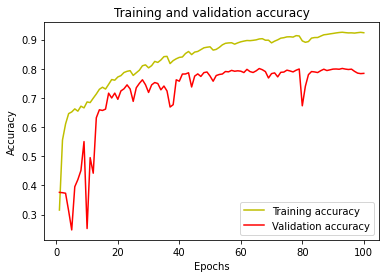

In [79]:
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) +1)
plt.plot(epochs, accuracy, "y", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show();

In [81]:
model_resnet_backbone.save("resnet_backbone.hdf5")

In [82]:
model = load_model("resnet_backbone.hdf5")

In [88]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

3/3 [==============================] - 1s 263ms/step


In [91]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]
test_img_input= np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 39ms/step


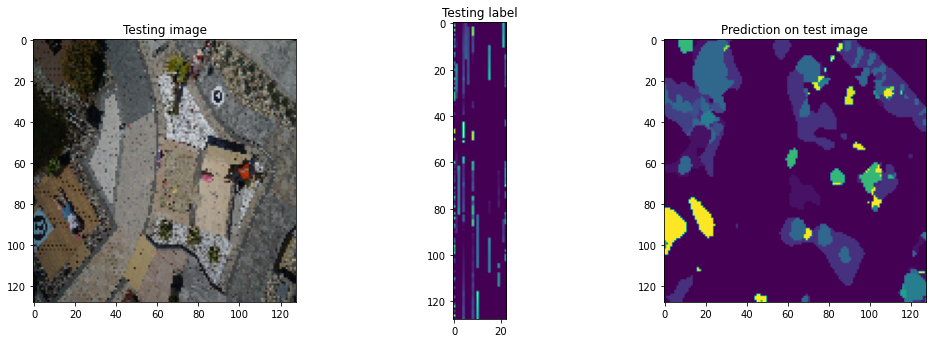

In [92]:
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title("Testing image")
plt.imshow(test_img)
plt.subplot(232)
plt.title("Testing label")
plt.imshow(ground_truth)
plt.subplot(233)
plt.title("Prediction on test image")
plt.imshow(predicted_img)
plt.show();

In [93]:
patch_size = 1000

In [94]:
def patched_data_load(folder_dir, patch_size):
    image_dataset = []
    
    random.seed(a=42)
    for images in tqdm(random.sample(os.listdir(folder_dir), 100)):
        image = cv2.imread(folder_dir+"/"+images, 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = Image.fromarray(image)
        image = np.array(image)
        
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patched_img = patches_img[i, j, :,:]
                
                
                single_patched_img = single_patched_img[0]
                single_patched_img = cv2.resize(single_patched_img, (128, 128))
                image_dataset.append(single_patched_img)
                
    return image_dataset

In [96]:
patched_image_dataset = patched_data_load(r"E:\python\mathmatic\datas\archive\dataset\semantic_drone_dataset\original_images", patch_size)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.46it/s]


In [103]:
patched_mask_dataset = patched_data_load(r"E:\python\mathmatic\datas\archive\RGB_color_image_masks\RGB_color_image_masks", patch_size)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.48it/s]


In [104]:
patched_image_dataset = np.array(patched_image_dataset)

In [105]:
patched_mask_dataset = np.array(patched_mask_dataset)

In [106]:
patched_image_dataset.shape

(2400, 128, 128, 3)

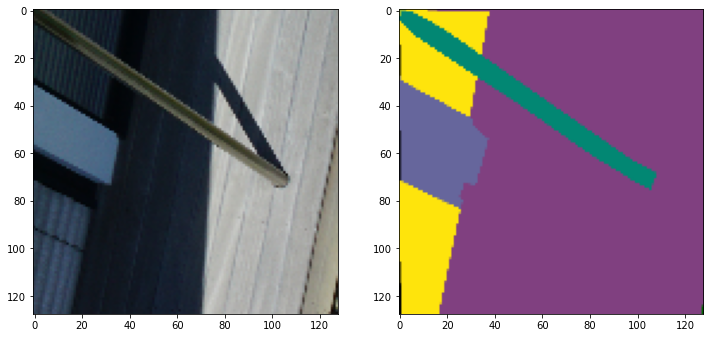

In [107]:
image_number = random.randint(0, len(patched_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(patched_image_dataset[image_number])
plt.subplot(122)
plt.imshow(patched_mask_dataset[image_number])
plt.show();

In [110]:
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape, dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1, 2, 3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]
    return label_seg

In [112]:
patched_labels = []
for i in tqdm(range(patched_mask_dataset.shape[0])):
    patched_label = rgb_to_labels(patched_mask_dataset[i], mask_labels)
    patched_labels.append(patched_label)

100%|██████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:27<00:00, 88.64it/s]


In [113]:
patched_labels = np.array(patched_labels)
patched_labels = np.expand_dims(patched_labels, axis=3)

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


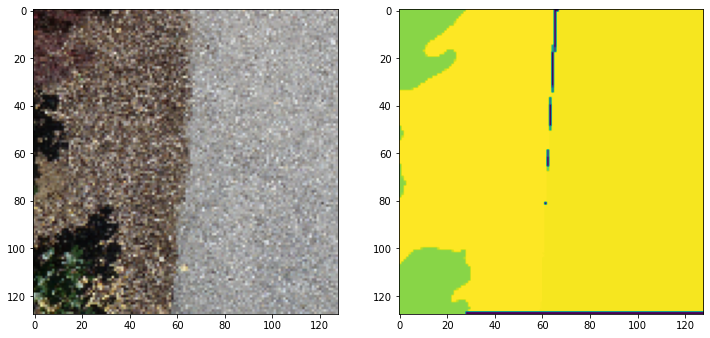

In [116]:
print("Unique labels in label dataset are: ", np.unique(patched_labels))

image_number = random.randint(0, len(patched_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(patched_image_dataset[image_number])
plt.subplot(122)
plt.imshow(patched_mask_dataset[image_number][:,:,0])
plt.show();

In [117]:
n_classes = len(np.unique(patched_labels))
patched_labels_cat = to_categorical(patched_labels, num_classes=n_classes)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(patched_image_dataset, patched_labels_cat, test_size=0.2, random_state=42)

In [119]:
BACKBONE = "resnet34"
preprocess_input = sm.get_preprocessing(BACKBONE)

In [120]:
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [122]:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights="imagenet", classes=n_classes, activation="softmax")

In [123]:
tf.keras.backend.clear_session()

In [129]:
metrics = ['accuracy']
opt = Adam(learning_rate=0.002)
model_resnet_backbone.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)

In [130]:
checkpoint = ModelCheckpoint(filepath=r"patched_resnet_backbone.h5", verbose=2, save_best_only=True)
early_stop = EarlyStopping(monitor="accuracy", min_delta=0, patience=5)
callbacks = [checkpoint, early_stop]

In [131]:
history1 = model_resnet_backbone.fit(X_train_prepr,
            y_train,
            batch_size=32,
            epochs=100,
            callbacks=callbacks,
            verbose=1,
            validation_data=(X_test_prepr, y_test))

Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 1.6894 - accuracy: 0.5500
Epoch 1: val_loss improved from inf to 724127.87500, saving model to patched_resnet_backbone.h5
60/60 [==============================] - 164s 3s/step - loss: 1.6894 - accuracy: 0.5500 - val_loss: 724127.8750 - val_accuracy: 0.1986
Epoch 2/100
60/60 [==============================] - ETA: 0s - loss: 1.2332 - accuracy: 0.6512
Epoch 2: val_loss improved from 724127.87500 to 16.99407, saving model to patched_resnet_backbone.h5
60/60 [==============================] - 157s 3s/step - loss: 1.2332 - accuracy: 0.6512 - val_loss: 16.9941 - val_accuracy: 0.3631
Epoch 3/100
60/60 [==============================] - ETA: 0s - loss: 1.1236 - accuracy: 0.6784
Epoch 3: val_loss improved from 16.99407 to 1.79408, saving model to patched_resnet_backbone.h5
60/60 [==============================] - 157s 3s/step - loss: 1.1236 - accuracy: 0.6784 - val_loss: 1.7941 - val_accuracy: 0.5393
Epoch 4/100
60/60 [=======

Epoch 29/100
60/60 [==============================] - ETA: 0s - loss: 0.7159 - accuracy: 0.7828
Epoch 29: val_loss did not improve from 0.74672
60/60 [==============================] - 157s 3s/step - loss: 0.7159 - accuracy: 0.7828 - val_loss: 0.9575 - val_accuracy: 0.7092
Epoch 30/100
60/60 [==============================] - ETA: 0s - loss: 0.7160 - accuracy: 0.7819
Epoch 30: val_loss did not improve from 0.74672
60/60 [==============================] - 157s 3s/step - loss: 0.7160 - accuracy: 0.7819 - val_loss: 0.9594 - val_accuracy: 0.7152
Epoch 31/100
60/60 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.7907
Epoch 31: val_loss did not improve from 0.74672
60/60 [==============================] - 160s 3s/step - loss: 0.6925 - accuracy: 0.7907 - val_loss: 0.7755 - val_accuracy: 0.7691
Epoch 32/100
60/60 [==============================] - ETA: 0s - loss: 0.6740 - accuracy: 0.7961
Epoch 32: val_loss did not improve from 0.74672
60/60 [===========================

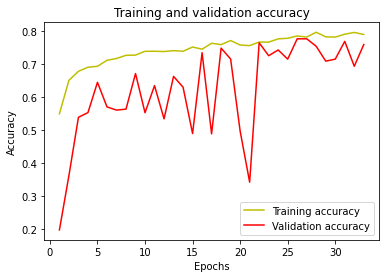

In [132]:
history = history1
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "y", label='Training accuracy')
plt.plot(epochs, val_accuracy, "r", label='Validation accuracy')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [133]:
patched_model = load_model("patched_resnet_backbone.h5")

In [134]:
y_pred = patched_model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

15/15 [==============================] - 5s 324ms/step


1/1 [==============================] - 1s 502ms/step


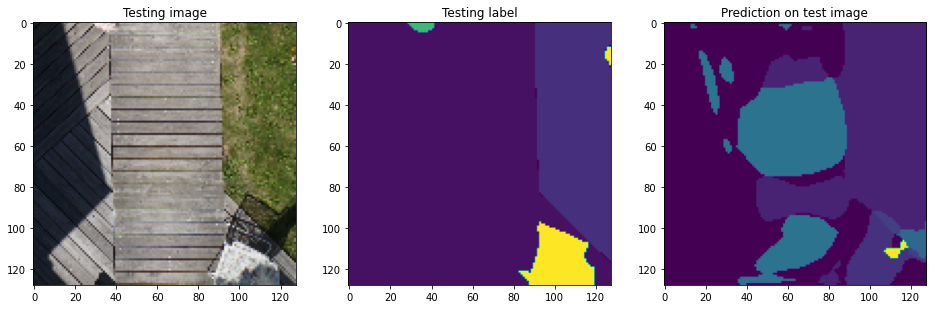

In [135]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
predictoin = (patched_model.predict(test_img_input))
predicted_img = np.argmax(predictoin, axis=3)[0,:,:]

plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title("Testing image")
plt.imshow(test_img)
plt.subplot(232)
plt.title("Testing label")
plt.imshow(ground_truth)
plt.subplot(233)
plt.title("Prediction on test image")
plt.imshow(predicted_img)
plt.show();